In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

#import Lambda
from tensorflow.keras.layers import Lambda

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  load_img
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Lambda
#import concatenate
from tensorflow.keras.layers import Concatenate

c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [2]:
# load mnist dataset from keras

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]

In [3]:
# define triplet generator

def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            positive_samples = random.sample(list(x_train[y_train == pos_neg[0]]), 2)
            negative_sample = random.choice(list(x_train[y_train == pos_neg[1]]))

            a.append(positive_samples[0])
            p.append(positive_samples[1])
            n.append(negative_sample)
        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [4]:
def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:100]
    positive_out = y_pred[:, 100:200]
    negative_out = y_pred[:, 200:300]

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

    probs = K.softmax([pos_dist, neg_dist], axis=0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))



input_layer = Input((28, 28, 1))
X = Conv2D(32, (3, 3), activation="relu")(input_layer)
X = MaxPool2D()(X)
X = Conv2D(64, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Conv2D(128, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Flatten()(X)
X = Dense(100, activation="relu")(X)

model = Model(input_layer, X)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [5]:
triplet_model_a = Input((28, 28, 1))
triplet_model_p = Input((28, 28, 1))
triplet_model_n = Input((28, 28, 1))

triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 100)          105572      ['input_2[0][0]',                
                                                                  'input_3[0][0]',          

In [6]:
triplet_model.compile(loss = triplet_loss, optimizer='adam')

In [7]:
triplet_model.fit(data_generator(), epochs=3, steps_per_epoch=50)

Epoch 1/3
50/50 [==============================] - 82s 1s/step - loss: 0.3353
Epoch 2/3
50/50 [==============================] - 73s 1s/step - loss: 0.1462
Epoch 3/3
50/50 [==============================] - 72s 1s/step - loss: 0.1037


In [15]:
model_embeddings_test = triplet_model.layers[3].predict(x_test)
model_embeddings_train = triplet_model.layers[3].predict(x_train)

1875/1875 [==============================] - 5s 3ms/step


In [16]:
reduced_embeddings_train = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train)
print(reduced_embeddings_train.shape)

(60000, 2)


In [17]:
reduced_embeddings_test = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_test)
print(reduced_embeddings_test.shape)

(10000, 2)


In [10]:
import matplotlib.pyplot as plt

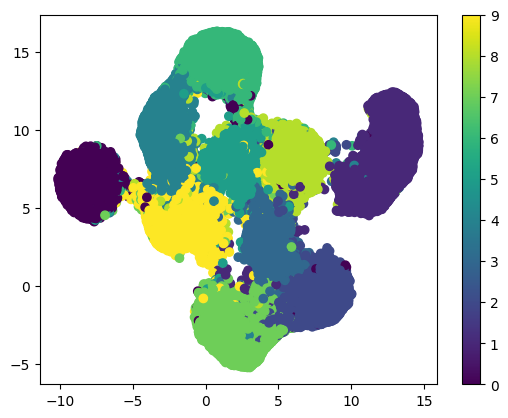

In [19]:
plt.scatter(reduced_embeddings_train[:, 0], reduced_embeddings_train[:,1], c=y_train)
plt.colorbar()

In [20]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100)

rf.fit(reduced_embeddings_train, y_train)

print(rf.score(reduced_embeddings_train, y_train))

1.0


In [21]:
print(rf.score(reduced_embeddings_test, y_test))

0.8833


juntar as imagens do mnist e mnist m na mesma classe

In [22]:
# juntar as imagens do mnist e mnistm na mesma classe

# Path: mnistm.py
import os
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# each folder contains images of a specific digit
# root folder "/mnistm_labels"
def load_mnistm():
    root = "mnistm_labels"
    folders = os.listdir(root)
    images = []
    labels = []
    for folder in folders:
        for image_path in os.listdir(os.path.join(root, folder)):
            image = Image.open(os.path.join(root, folder, image_path))
            image = np.array(image)
            images.append(image)
            labels.append(int(folder))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# load mnistm dataset

x_train_m, y_train_m = load_mnistm()


In [32]:
x_train.shape

(60000, 28, 28, 1)

In [37]:
y_train_m

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

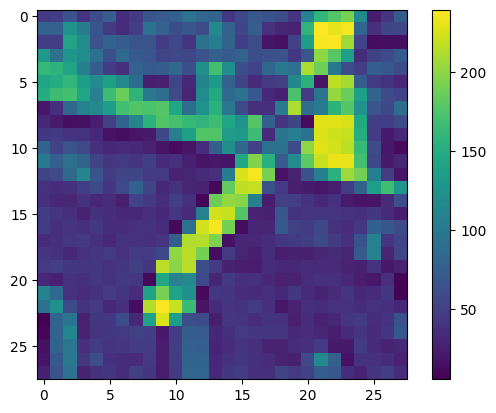

In [62]:
plt.imshow(x_train_m[52].mean(axis=-1))
plt.colorbar()

In [25]:
x_train_m.shape, y_train_m.shape

((288, 28, 28, 3), (288,))

In [26]:
all_images = np.concatenate([x_train, x_train_m], axis=0)
all_images

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 1 and the array at index 1 has size 3